In [1]:
# pip install -U scikit-learn

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
# %matplotlib inline

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error

In [39]:
/pwd

'C:\\Users\\PrizeJune\\Desktop\\kr_finbert\\model'

In [40]:
# 로우 데이터로 엑셀파일 로드
# 실행 전에 미리 구글 드라이브 마운트를 해야하고 동일 경로에서 엑셀파일을 읽어들여야 함
# raw_data = pd.read_excel('samsung_stock_dataset_finBERT_notnull.xlsx') # 삼성
raw_data = pd.read_excel('../datasets/samsung/samsung_stock_dataset_finBERT_notnull.xlsx') # 현대

raw_data = raw_data.set_index("Date")
raw_data = raw_data.drop(['PSAR-up','PSAR-down'],axis=1)
print(raw_data.shape)
raw_data = raw_data.dropna(axis=0) # 널값 있는 행 제거
raw_data

(1235, 35)


,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,MACD-sign,PSAR,RSI,ADX,OBV,OSCILLATOR,negative,neutral,positive,sentiment
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-22,42000,42650,42000,42450,5970796,0.008314,1.008314,0.990828,0.038202,0.082674,...,-165.608567,45051.520000,40.881416,18.101735,-13453907,-417.647059,0.030520,0.000077,0.969403,1
2018-11-23,42450,42600,41900,42400,5192638,-0.001178,0.998822,0.996927,0.037061,0.079820,...,-198.150335,44921.459200,40.567862,17.555025,-18646545,-731.029412,0.101236,0.007946,0.890818,1
2018-11-26,42150,42800,42100,42600,6613009,0.004717,1.004717,1.003951,0.028850,0.079954,...,-228.743219,44796.600832,42.468657,16.765372,-12033536,-944.852941,0.171952,0.015814,0.812233,1
2018-11-27,42900,43100,42500,43050,8367091,0.010563,1.010563,1.004701,0.030665,0.080638,...,-248.810012,44676.736799,46.606462,15.616858,-3666445,-830.147059,0.046501,0.000300,0.953199,1
2018-11-28,42800,43200,42750,43150,6943099,0.002323,1.002323,1.005868,0.030439,0.079615,...,-259.064789,44561.667327,47.509934,14.590579,3276654,-618.676471,0.762649,0.123316,0.114036,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,-195.275368,68482.938629,48.344501,10.158162,648378263,148.529412,0.001084,0.998356,0.000561,0
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,-201.601331,68423.279857,41.458445,10.635226,629022508,47.941176,0.000039,0.000086,0.999876,1
2022-06-08,65400,65700,65300,65300,12483180,-0.003053,0.996947,0.992995,0.035631,0.072318,...,-225.574382,68302.348663,40.502621,11.151145,616539328,-289.705882,0.000019,0.000043,0.499938,1


In [41]:
raw_data["Next Day Close"] = raw_data.Close.shift(-1)
raw_data = raw_data.dropna()
raw_data.shape

(874, 36)

In [42]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd

,Open,High,Low,Close,Volume,Change,Rn,MRn,Volatility10,Volatility30,...,MA360,ATR,MACD-line,MACD-hist,MACD-sign,PSAR,RSI,ADX,OBV,OSCILLATOR
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-22,42000,42650,42000,42450,5970796,0.008314,1.008314,0.990828,0.038202,0.082674,...,48656.527778,1116.952769,-274.080544,-108.471978,-165.608567,45051.520000,40.881416,18.101735,-13453907,-417.647059
2018-11-23,42450,42600,41900,42400,5192638,-0.001178,0.998822,0.996927,0.037061,0.079820,...,48646.638889,1087.170429,-328.317410,-130.167074,-198.150335,44921.459200,40.567862,17.555025,-18646545,-731.029412
2018-11-26,42150,42800,42100,42600,6613009,0.004717,1.004717,1.003951,0.028850,0.079954,...,48637.361111,1059.515398,-351.114756,-122.371536,-228.743219,44796.600832,42.468657,16.765372,-12033536,-944.852941
2018-11-27,42900,43100,42500,43050,8367091,0.010563,1.010563,1.004701,0.030665,0.080638,...,48631.111111,1026.692869,-329.077180,-80.267169,-248.810012,44676.736799,46.606462,15.616858,-3666445,-830.147059
2018-11-28,42800,43200,42750,43150,6943099,0.002323,1.002323,1.005868,0.030439,0.079615,...,48625.527778,985.500522,-300.083899,-41.019110,-259.064789,44561.667327,47.509934,14.590579,3276654,-618.676471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02,66600,67000,66400,66700,14959443,-0.010386,0.989614,1.001076,0.033406,0.070579,...,76687.222222,1181.734320,-121.572679,91.703121,-213.275800,68543.814928,47.724304,10.877366,640155380,-22.352941
2022-06-03,67200,67300,66800,66800,8222883,0.001499,1.001499,0.995561,0.032744,0.070580,...,76667.777778,1140.181869,-123.273642,72.001726,-195.275368,68482.938629,48.344501,10.158162,648378263,148.529412
2022-06-07,66200,66400,65400,65500,19355755,-0.019461,0.980539,0.990551,0.035700,0.072899,...,76646.111111,1158.740307,-226.905181,-25.303850,-201.601331,68423.279857,41.458445,10.635226,629022508,47.941176


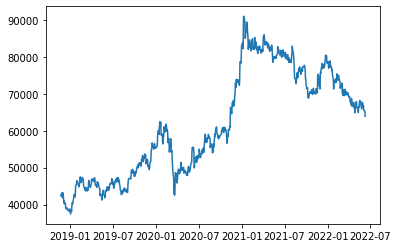

In [43]:
raw_X_A = raw_data.iloc[:, :31]
# raw_X_A = raw_data.iloc[:, :34] # negative, neutral, positive 각 수치가 들어간 데이터프레임
# raw_X_A = pd.concat([raw_data.iloc[:, :31], raw_data.iloc[:,34]], axis=1) # negative, neutral, positive의 대표값이 들어간 데이터프레임
raw_y = raw_data.iloc[:, 35:36] # 다음날 종가 데이터가 들어있음
raw_X_A
# raw_X_A = raw_X_A.dropna()
# raw_y = raw_y.dropna()

plt.plot(raw_y, label = 'samsung')
plt.show()

In [44]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X_A)
sc_y = sc.fit_transform(raw_y)

train_size = int(len(sc_y) * 0.67)
test_size = len(sc_y) - train_size

# 텐서화? 하기
dataX = Variable(torch.Tensor(np.array(sc_X)))
dataY = Variable(torch.Tensor(np.array(sc_y)))

# train 데이터 2/3으로 자르기
trainX = Variable(torch.Tensor(np.array(sc_X[0:train_size])))
trainY = Variable(torch.Tensor(np.array(sc_y[0:train_size])))

# test 데이터 나머지 1/3으로 자르기
testX = Variable(torch.Tensor(np.array(sc_X[train_size:len(sc_X)])))
testY = Variable(torch.Tensor(np.array(sc_y[train_size:len(sc_y)])))

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

# lstm 모델에 적용할 때 shape을 변경해줘야 함 
# reshape(a, (b,1,c)) 형태로 모델에 돌리기 위해 2차원으로 바꿔주는 것임

trainX_fin = torch.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX_fin = torch.reshape(testX, (testX.shape[0], 1, testX.shape[1])) 

dataX_fin = torch.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
print("Training Shape", trainX_fin.shape, trainY.shape)
print("Testing Shape", testX_fin.shape, testY.shape) 
print(dataX_fin.shape, dataY.shape)

torch.Size([585, 31])
torch.Size([289, 31])
torch.Size([585, 1])
torch.Size([289, 1])
Training Shape torch.Size([585, 1, 31]) torch.Size([585, 1])
Testing Shape torch.Size([289, 1, 31]) torch.Size([289, 1])
torch.Size([874, 1, 31]) torch.Size([874, 1])


In [45]:
# 모델 정의하기

class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.relu(h_out)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out


In [46]:
num_epochs = 20000
learning_rate = 0.005

input_size = trainX_fin.shape[2] # 컬럼 개수
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, trainX_fin.shape[1])

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX_fin)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05886
Epoch: 100, loss: 0.00138
Epoch: 200, loss: 0.00085
Epoch: 300, loss: 0.00063
Epoch: 400, loss: 0.00053
Epoch: 500, loss: 0.00047
Epoch: 600, loss: 0.00044
Epoch: 700, loss: 0.00041
Epoch: 800, loss: 0.00040
Epoch: 900, loss: 0.00039
Epoch: 1000, loss: 0.00038
Epoch: 1100, loss: 0.00037
Epoch: 1200, loss: 0.00037
Epoch: 1300, loss: 0.00036
Epoch: 1400, loss: 0.00036
Epoch: 1500, loss: 0.00036
Epoch: 1600, loss: 0.00035
Epoch: 1700, loss: 0.00035
Epoch: 1800, loss: 0.00035
Epoch: 1900, loss: 0.00034
Epoch: 2000, loss: 0.00034
Epoch: 2100, loss: 0.00034
Epoch: 2200, loss: 0.00034
Epoch: 2300, loss: 0.00034
Epoch: 2400, loss: 0.00034
Epoch: 2500, loss: 0.00033
Epoch: 2600, loss: 0.00033
Epoch: 2700, loss: 0.00033
Epoch: 2800, loss: 0.00041
Epoch: 2900, loss: 0.00033
Epoch: 3000, loss: 0.00039
Epoch: 3100, loss: 0.00033
Epoch: 3200, loss: 0.00033
Epoch: 3300, loss: 0.00032
Epoch: 3400, loss: 0.00032
Epoch: 3500, loss: 0.00033
Epoch: 3600, loss: 0.00036
Epoch: 3700, 

LSTM(
  (lstm): LSTM(31, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

Text(0.5, 0.98, 'Time-Series Prediction_LSTM')

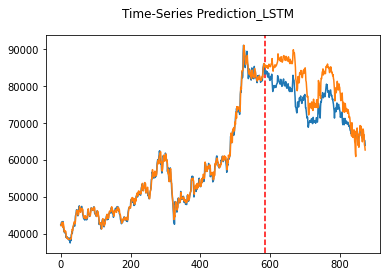

,True,Pred,close,direction,direc_pred
0,42400.000000,42165.500000,42450,0,0
1,42600.000000,42179.214844,42400,1,0
2,43050.000000,42520.773438,42600,1,0
3,43150.000000,42883.582031,43050,1,0
4,43150.000000,43040.472656,43150,1,0
...,...,...,...,...,...
869,66800.000000,66645.093750,66700,1,0
870,65500.003906,66674.265625,66800,0,0
871,65300.003906,64064.515625,65500,0,0
872,65200.003906,63615.937500,65300,0,0


MSE : 10322017.0, RMSE : 3212.78955078125, SCORE : 47.1%


In [47]:
# 모델 평가하기
lstm.eval()

# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것

# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = lstm(dataX_fin)

# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()

# 예측값: data_predict
# 실제값: dataY_plot

data_predict_fin = list(data_predict.flatten())
dataY_plot_fin = list(dataY_plot.flatten())

score_table = pd.DataFrame({'True': dataY_plot_fin,
                            'Pred': data_predict_fin})


# -----
score_table['close'] = list(raw_data['Close'])

# i[1][0] # True
# i[1][1] # Pred
# i[1][2] # close
# 1: up
# 0: down
# cnt: up&down 맞춘 갯수
# result: up&down 예측 정확도

direction = []
direc_pred = []
for i in score_table.iterrows():
    if i[1][0] >= i[1][2]:
        direction.append(1)
    else:
        direction.append(0)

for i in score_table.iterrows():
    if i[1][1] >= i[1][2]:
        direc_pred.append(1)
    else:
        direc_pred.append(0)

score_table['direction'] = direction
score_table['direc_pred'] = direc_pred

cnt = 0
for i in score_table.iterrows():
    if i[0] >= train_size:
        if i[1][3] == i[1][4]:
            cnt += 1

result = cnt/(len(score_table)-train_size)*100
result = result
# -----

display(score_table)

# validation score
MSE = mean_squared_error(score_table['True'], score_table['Pred'])
RMSE = np.sqrt(MSE)

print(f"MSE : {MSE}, RMSE : {RMSE}, SCORE : {result:.1f}%")

In [48]:
# *-- ARIMA 방법론 구현 --*
from statsmodels.tsa.arima.model import ARIMA

In [49]:
# X, y 데이터를 0~1 사이 값으로 정규화 
# 학습이 잘되기 위해 하는 것이고, 이 값은 추후 inverse로 도로 되돌림
sc = MinMaxScaler()
sc_X = sc.fit_transform(raw_X_A)
sc_y = sc.fit_transform(raw_y)

validataion_size = 0.33
train_size = int(len(sc_X) * (1-validataion_size))
X_train, X_test = sc_X[:train_size], sc_X[train_size:len(sc_X)]
y_train, y_test = sc_y[:train_size], sc_y[train_size:len(sc_y)]

In [50]:
num_folds = 10
scoring = 'neg_mean_squared_error'


X_train_ARIMA = X_train
X_test_ARIMA = X_test

In [51]:
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(sc_X)
tr_len, te_len, to_len

(585, 289, 874)

In [52]:
model = ARIMA(endog=y_train, exog=X_train_ARIMA, order=[2,1,2])

In [53]:
model_fit = model.fit()
trained_predicted = model_fit.predict()

C:\ProgramData\Anaconda3\envs\kr_finbert\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [54]:
error_Training_ARIMA = mean_squared_error(y_train, model_fit.fittedvalues)
error_Train_ARIMA = mean_squared_error
error_Test_ARIMA = mean_squared_error(y_test, predicted)
print(error_Training_ARIMA)
print(error_Test_ARIMA)

105805517965.60675
0.02368378410202813


In [ ]:
# 전체 데이터 예측 값(Y)을 numpy array로 변경


# 학습시킨 모델에 전체 데이터를 적용시켜 Y를 추출한 것

# 전체 데이터의 2/3인 train 데이터까지는 모델 학습에서 사용했던 데이터이고
# 1/3인 test 데이터는 모델이 예측한 값
train_predict = model_fit.predict(start=0, end=to_len - 1, exos=np.concatenate((X_train, X_test), axis = 0))[1:]
# 전체 데이터 예측 값(Y)을 numpy array로 변경
data_predict = train_predict.data.numpy()

# 실제 Y데이터 값을 numpy array로 변경
dataY = y_train + y_test
dataY_plot = dataY.data.numpy()

# 위에서 모델에 적용하려고 0~1 사이로 정규화했던 값을 다시 inverse
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

# 학습에 사용됐던 데이터와 예측한 값의 경계를 선으로 표현
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction_LSTM')
plt.show()